In [1]:
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 导入数据

In [2]:
df_train = pd.read_csv('../train.csv', header=None)
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/4d8a38b29930a403e5...,collar_design_labels,nnynn
1,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
3,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
4,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn


In [3]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels', 
           'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels', 
           'pant_length_labels']
len(classes)

8

### 加载数据

In [4]:
cur_class = classes[0]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 8393


,image_id,class,label
0,Images/collar_design_labels/4d8a38b29930a403e5...,collar_design_labels,nnynn
1,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
3,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
4,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn


In [5]:
df_load[(df_load.index == 2)]

,image_id,class,label
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn


In [6]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)

for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    if len(tmp_label) > n_class:
        print(df_load['image_id'][i])
    X[i] = cv2.resize(cv2.imread('../train/{0}'.format(df_load['image_id'][i])), (width, width))
    y[i][tmp_label.find('y')] = 1

100%|██████████| 8393/8393 [00:42<00:00, 195.21it/s]


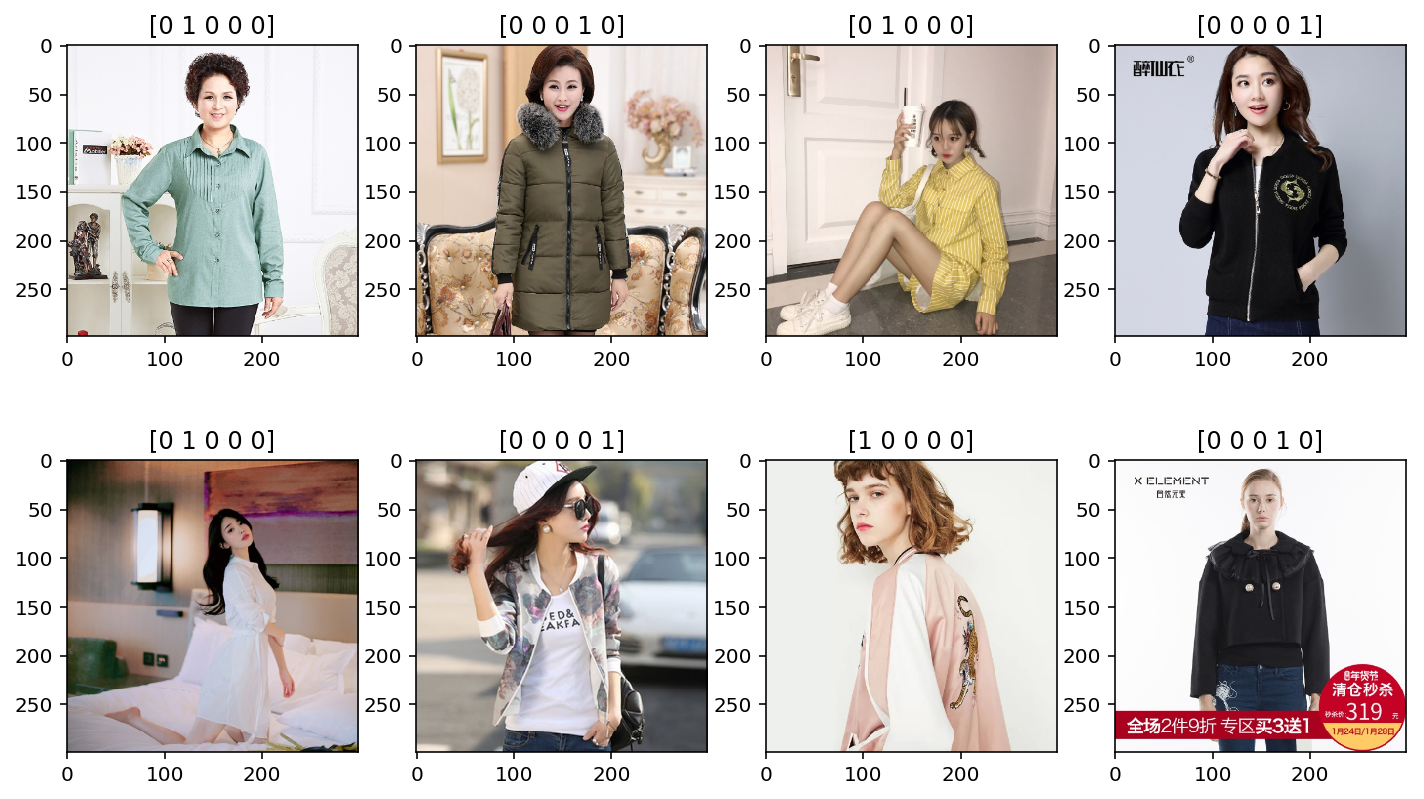

In [7]:
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(y[random_index])

### 提取特征

In [8]:
#用于指定后端
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [9]:
from keras.layers import *
#from keras.layers import Input
from keras.models import *
#from keras.models import Model
#from keras.layers import Input, Dense
#a = Input(shape=(32,))
#b = Dense(32)(a)
#model = Model(inputs=a, outputs=b)
from keras.callbacks import *
from keras.optimizers import *
from keras.regularizers import *


# 
from keras.applications import *
from keras.applications import ResNet50

from keras.applications import VGG16
from keras.applications import VGG19

from keras.applications import Xception # TensorFlow ONLY
from keras.applications import InceptionResNetV2
from keras.applications import InceptionV3
#tf.keras.applications.inception_v3.InceptionV3
#tf.keras.applications.inception_resnet_v2.InceptionResNetV2

#导入的image_utils包包含了一系列函数，使得对图片进行前处理以及对分类结果解码更加容易
#VGG16，VGG19以及ResNet接受224×224的输入图像， 而Inception V3和Xception要求为299×299



#使用合适的预处理函数来执行mean subtraction/scaling
#预处理 图像编码服从规定，譬如,RGB，GBR这一类的，preprocess_input(x)  

#preprocessing function is also different (same as Xception)
#return imagenet_utils.preprocess_input(x, mode='tf')
#而其他VGG16，VGG19以及ResNet接受224×224的输入图像,使用preprocess = imagenet_utils.preprocess_input预处理
#InceptionV3和Xception,还有
from keras.applications.inception_v3 import preprocess_input
#from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
#import numpy as np
#import argparse
#import cv2

Using TensorFlow backend.


In [12]:


#input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
#pooling: Optional pooling mode for feature extraction when include_top is False. - None means that the output of the model will be the 4D tensor output of the last convolutional layer. - 'avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor. - 'max' means that global max pooling will be applied.
#cnn_model = Xception(include_top=False,input_shape=(width, width, 3), weights='imagenet',)
#当include_top=False,即在最后卷积末尾新加pooling='avg'的全局均值采用,得到全局滤波器个数*1的二维输出
cnn_model = InceptionV3(include_top=False, input_shape=(width, width, 3), weights='imagenet',pooling='avg')

inputs = Input((width, width, 3))
x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
#下面是新加的层
#x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# n_class为对应属性的分类个数
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

### 划分训练、测试集

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.12, random_state=42)
X_train.shape, y_train.shape

((7385, 299, 299, 3), (7385, 5))

In [14]:
adam = Adam(lr=0.001)
prefix_cls = cur_class.split('_')[0]

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='../models/{0}.best.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

h = model.fit(X_train, y_train, batch_size=32, epochs=80, 
              callbacks=[EarlyStopping(patience=3), checkpointer], 
              shuffle=True, 
              validation_split=0.1)

Train on 6646 samples, validate on 739 samples
Epoch 1/80
6646/6646 [==============================] - 89s 13ms/step - loss: 1.0787 - acc: 0.5856 - val_loss: 1.9946 - val_acc: 0.4208

Epoch 00001: val_loss improved from inf to 1.99464, saving model to ../models/collar.best.h5
Epoch 2/80
6646/6646 [==============================] - 75s 11ms/step - loss: 0.7106 - acc: 0.7480 - val_loss: 0.8910 - val_acc: 0.7050

Epoch 00002: val_loss improved from 1.99464 to 0.89098, saving model to ../models/collar.best.h5
Epoch 3/80
6646/6646 [==============================] - 74s 11ms/step - loss: 0.5656 - acc: 0.7990 - val_loss: 0.8211 - val_acc: 0.7172

Epoch 00003: val_loss improved from 0.89098 to 0.82115, saving model to ../models/collar.best.h5
Epoch 4/80
6646/6646 [==============================] - 78s 12ms/step - loss: 0.4485 - acc: 0.8428 - val_loss: 0.7511 - val_acc: 0.7388

Epoch 00004: val_loss improved from 0.82115 to 0.75105, saving model to ../models/collar.best.h5
Epoch 5/80
6646/6646 

Text(0.5,0,'epoch')

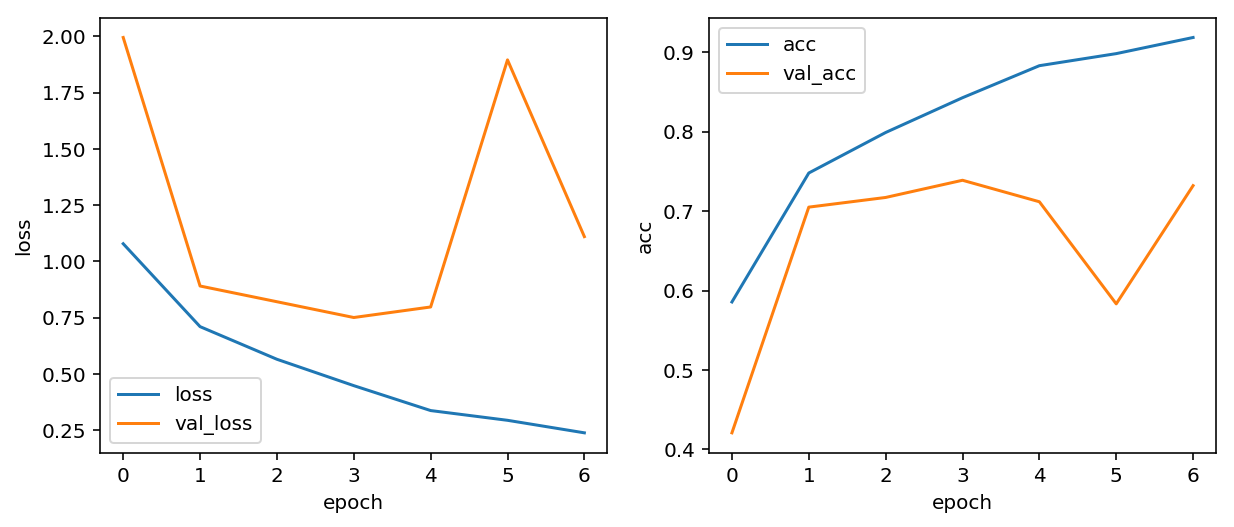

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [16]:
model.evaluate(X_train, y_train, batch_size=256)

7385/7385 [==============================] - 54s 7ms/step


[0.48095776211513241, 0.85565335216276861]

In [17]:
model.evaluate(X_valid, y_valid, batch_size=256)

1008/1008 [==============================] - 8s 8ms/step


[1.1448318844749814, 0.71924602606939891]

### 加载测试集

In [19]:
df_test = pd.read_csv('../test/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels


In [20]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 1082


,image_id,class
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels


In [21]:
n = len(df_load)
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('../test/{0}'.format(df_load['image_id'][i])), (width, width))

100%|██████████| 1082/1082 [00:09<00:00, 108.53it/s]


In [22]:
test_np = model.predict(X_test, batch_size=256)

In [23]:
test_np.shape

(1082, 5)

In [24]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

,image_id,class,result
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels,0.0080;0.9868;0.0024;0.0027;0.0001
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels,0.0125;0.0018;0.0021;0.9768;0.0069
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels,0.0002;0.9998;0.0000;0.0000;0.0000
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels,0.8510;0.0062;0.0271;0.1085;0.0072
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels,0.3105;0.0254;0.2071;0.4479;0.0090


In [25]:
df_load.to_csv('../result/{}_fai0317.csv'.format(prefix_cls), header=None, index=False)
prefix_cls

'collar'